In [0]:
import os
from google.colab import auth
auth.authenticate_user()

## Fetching Data

In [4]:

!gsutil cp -r gs://steel-data/data/train.zip /content


Copying gs://steel-data/data/train.zip...
\ [1 files][  1.4 GiB/  1.4 GiB]   73.0 MiB/s                                   
Operation completed over 1 objects/1.4 GiB.                                      


In [0]:
%%capture
!unzip /content/train.zip
!gsutil cp -r gs://steel-data/data/train.csv /content
!gsutil cp -r gs://steel-data/data/sample_submission.csv /content
os.chdir('/content/')

In [6]:
for file in os.listdir():
  if file == "sample_submission.csv":
    print(file)


sample_submission.csv


In [0]:
import os
import json
import random

import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split


## Flags

In [0]:
ONLY_CLASSIFY = True
IMAGE_CHANNELS = 3

## PREPROCESSING

In [74]:
traindf=pd.read_csv('train.csv')
traindf['ImageId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[0])
traindf['ClassId'] = traindf['ImageId_ClassId'].apply(lambda x: x.split('_')[1])
traindf['hasMask'] = ~ traindf['EncodedPixels'].isna()
traindf.head()

,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
1,0002cc93b.jpg_2,NaN,0002cc93b.jpg,2,False
2,0002cc93b.jpg_3,NaN,0002cc93b.jpg,3,False
3,0002cc93b.jpg_4,NaN,0002cc93b.jpg,4,False
4,00031f466.jpg_1,NaN,00031f466.jpg,1,False


### Defect vs Non Defect
### Class at 0 is Non defective class, others are defective classes.

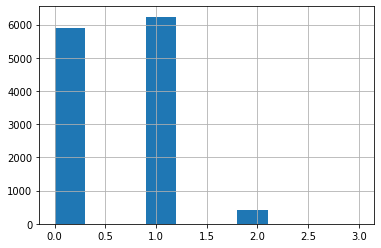

In [101]:
idf=traindf.groupby('ImageId')['hasMask'].agg(sum)
idf.hist()

In [53]:
traindf= traindf[traindf.hasMask == True]
traindf.head()


,ImageId_ClassId,EncodedPixels,ImageId,ClassId,hasMask
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,True
18,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...,0007a71bf.jpg,3,True
20,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...,000a4bcdd.jpg,1,True
27,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...,000f6bf48.jpg,4,True
30,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...,0014fce06.jpg,3,True


### Defect class distribution


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f45f2c5abe0>]],
      dtype=object)

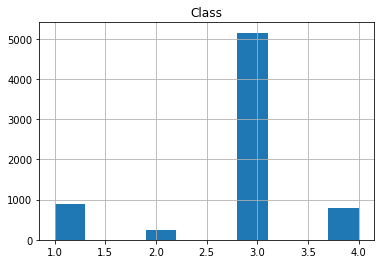

In [54]:
traindf['Class'] = traindf.ClassId.astype(int)
traindf.hist(column=["Class"])

In [12]:
(filtereddf = traindf.groupby('ImageId')['ClassId'].apply(list).reset_index()
filtereddf.head()

,ImageId,ClassId
0,0002cc93b.jpg,[1]
1,0007a71bf.jpg,[3]
2,000a4bcdd.jpg,[1]
3,000f6bf48.jpg,[4]
4,0014fce06.jpg,[3]


In [0]:
#maskcountdf.ClassId = maskcountdf.ClassId.apply(lambda x : [0 if i == 0 else 1 for i in x])
#maskcountdf.head()

## Data Generation

In [122]:
train, test = train_test_split(filtereddf, test_size=0.12)

BATCH_SIZE = 16
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(rescale=1./255.,
                           zoom_range=0.1,
                           brightness_range=[0.6,1.0],
                           validation_split=0.15,
                           horizontal_flip=True,
                           vertical_flip=True
                           )

TRAIN_BATCH_SIZE=26
TEST_BATCH_SIZE=8
DATA_DIR='/content'
IMAGE_SIZE=(64, 400)

train_gen=datagen.flow_from_dataframe(
    dataframe=train,
    x_col="ImageId",
    y_col="ClassId",
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    subset='training',
  )

val_gen=datagen.flow_from_dataframe(
    dataframe=train,
    x_col="ImageId",
    y_col="ClassId",
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
    subset='validation'
)

test_gen=datagen.flow_from_dataframe(
    dataframe=test,
    x_col="ImageId",
    y_col="ClassId",
    directory=DATA_DIR,
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=False,
    class_mode='categorical',
    target_size=IMAGE_SIZE,
)

Found 4987 validated image filenames belonging to 4 classes.
Found 879 validated image filenames belonging to 4 classes.
Found 800 validated image filenames belonging to 4 classes.


## Resnet 50

In [0]:

def build_model(input_shape):

    ### Resnet 50
    pretrained_model = keras.applications.ResNet50V2(input_shape=input_shape, include_top=False)  #classes=5
    model = keras.Sequential([
        pretrained_model,
        keras.layers.Flatten(),
        keras.layers.Dense(16, activation='sigmoid'),
        keras.layers.Dense(4, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.SGD(), 
        loss=keras.losses.binary_crossentropy, 
        metrics=[tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 keras.metrics.AUC(name='auc')])
    return model

In [133]:
model = build_model((64, 400, IMAGE_CHANNELS))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 2, 13, 2048)       23564800  
_________________________________________________________________
flatten_9 (Flatten)          (None, 53248)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                851984    
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 68        
Total params: 24,416,852
Trainable params: 24,371,412
Non-trainable params: 45,440
_________________________________________________________________


In [134]:
checkpoint = ModelCheckpoint(
    'steel_only_defect_resnet50_f1_model.h5', 
    monitor='val_auc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    model='auto'
)

history = model.fit_generator(
    train_gen,
    validation_data=val_gen,
    callbacks=[checkpoint],
    use_multiprocessing=True,
    epochs=25,
    verbose=1
)

Epoch 1/25
312/312 [==============================] - 116s 373ms/step - loss: 0.3966 - precision: 0.7605 - recall: 0.7236 - auc: 0.8727 - val_loss: 0.3432 - val_precision: 0.7799 - val_recall: 0.7339 - val_auc: 0.9288
Epoch 2/25
312/312 [==============================] - 81s 259ms/step - loss: 0.3228 - precision: 0.7827 - recall: 0.7232 - auc: 0.9372 - val_loss: 0.2951 - val_precision: 0.7917 - val_recall: 0.7339 - val_auc: 0.9483
Epoch 3/25
312/312 [==============================] - 81s 261ms/step - loss: 0.2784 - precision: 0.8303 - recall: 0.7368 - auc: 0.9526 - val_loss: 0.2548 - val_precision: 0.8412 - val_recall: 0.7672 - val_auc: 0.9598
Epoch 4/25
312/312 [==============================] - 81s 261ms/step - loss: 0.2478 - precision: 0.8643 - recall: 0.7581 - auc: 0.9610 - val_loss: 0.2322 - val_precision: 0.9117 - val_recall: 0.7425 - val_auc: 0.9701
Epoch 5/25
312/312 [==============================] - 82s 261ms/step - loss: 0.2259 - precision: 0.8853 - recall: 0.7613 - auc: 0.9

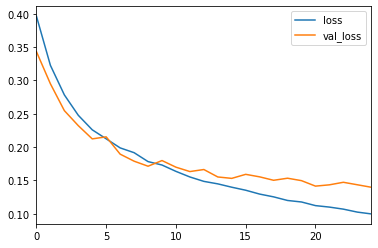

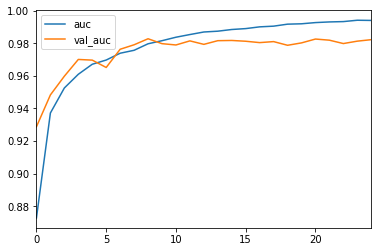

In [135]:
import json

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['auc', 'val_auc']].plot()

In [0]:
model.save('/home/steel_only_defect_resnet50_PR_AUC_model.h5')

## Test 

In [137]:
model.load_weights('/home/steel_only_defect_resnet50_PR_AUC_model.h5')

batch_pred = model.evaluate_generator(
    test_gen, 
    workers=1,
    verbose=1,
    use_multiprocessing=False
)   

50/50 [==============================] - 11s 229ms/step - loss: 0.1293 - precision: 0.9386 - recall: 0.8853 - auc: 0.9862
